# Stanford CME 241 (Winter 2025) - Assignment 2

**Due: Tuesday, February 4 @ 11:59 PM PST on Gradescope.**

Assignment instructions:
- Make sure each of the subquestions have answers
- Ensure that group members indicate which problems they're in charge of
- Show work and walk through your thought process where applicable
- Empty code blocks are for your use, so feel free to create more under each section as needed
- Document code with light comments (i.e. 'this function handles visualization')

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/ardbeg-10/RL-book/tree/master/assignments

*Group members (replace below names with people in your group):* 
- Yuteng Zhuang
- James Liu

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import List, Dict, Tuple
from dataclasses import dataclass
from typing import Tuple, Dict, Mapping, Iterable
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.policy import FiniteDeterministicPolicy
from rl.markov_process import FiniteMarkovProcess, FiniteMarkovRewardProcess
from rl.distribution import Categorical
from rl.dynamic_programming import policy_iteration_result
from scipy.stats import poisson
from __future__ import annotations
from scipy.stats import poisson
from pprint import pprint

## Question 1: Job-Hopping and Wages-Utility-Maximization (Led by Yuteng, James)

You are a worker who starts every day either employed or unemployed. If you start your day employed, you work on your job for the day (one of $n$ jobs, as elaborated later) and you get to earn the wage of the job for the day. However, at the end of the day, you could lose your job with probability $\alpha \in [0,1]$, in which case you start the next day unemployed. If at the end of the day, you do not lose your job (with probability $1-\alpha$), then you will start the next day with the same job (and hence, the same daily wage). 

On the other hand, if you start your day unemployed, then you will be randomly offered one of $n$ jobs with daily wages $w_1, w_2, \ldots w_n \in \mathbb{R}^+$ with respective job-offer probabilities $p_1, p_2, \ldots p_n \in [0,1]$ (with $\sum_{i=1}^n p_i = 1$). You can choose to either accept or decline the offered job. If you accept the job offer, your day progresses exactly like the **employed-day** described above (earning the day's job wage and possibly (with probability $\alpha$) losing the job at the end of the day). However, if you decline the job offer, you spend the day unemployed, receive the unemployment wage $w_0 \in \mathbb{R}^+$ for the day, and start the next day unemployed.

The problem is to identify the optimal choice of accepting or rejecting any of the job offers the worker receives, in a manner that maximizes the infinite-horizon **Expected Discounted-Sum of Wages Utility**. Assume the daily discount factor for wages (employed or unemployed) is $\gamma \in [0,1])$. Assume Wages Utility function to be $U(w) = \log(w)$ for any wage amount $w \in \mathbb{R}^+$. The goal is to maximize:

$$
\mathbb{E}\left[\sum_{u=t}^\infty \gamma^{u-t} \cdot \log(w_{i_u})\right]
$$

at the start of a given day $t$ ($w_{i_u}$ is the wage earned on day $u$, $0 \leq i_u \leq n$ for all $u \geq t$).

---

### Subquestions

#### Part (A): MDP Modeling

Express the job-hopping problem as an MDP using clear mathematical notation by defining the following components:

1. **State Space**: Define the possible states of the MDP.
2. **Action Space**: Specify the actions available to the worker at each state.
3. **Transition Function**: Describe the probabilities of transitioning between states for each action.
4. **Reward Function**: Specify the reward associated with the states and transitions.
5. **Bellman Optimality Equation**: Write the Bellman Optimality Equation customized for this MDP.

---

#### Part (B): Python Implementation

Write Python code that:

1. Solves the Bellman Optimality Equation (hence, solves for the **Optimal Value Function** and the **Optimal Policy**) with a numerical iterative algorithm. 
2. Clearly define the inputs and outputs of your algorithm with their types (`int`, `float`, `List`, `Mapping`, etc.).

*Note*: For this problem, write the algorithm from scratch without using any prebuilt MDP/DP libraries or code.

---

#### Part (C): Visualization and Analysis

1. Plot the **Optimal Value Function** as a function of the state for a specific set of parameters ($n$, $w_1, \ldots, w_n$, $p_1, \ldots, p_n$, $\alpha$, $\gamma$, $w_0$).
2. Include these graphs in your submission.

---

#### Part (D): Observations

1. What patterns do you observe in the **Optimal Policy** as you vary the parameters $n$, $\alpha$, and $\gamma$?
2. Provide a brief discussion of your findings.

---

### Part (A) Answer

- State Space:
{0, 1, 2, 3, ..., n}, where 0 represents uneployment, any other number $i$ represents employed by job $i$.

- Action Space: There are two cases,
    - If the worker is employed, no action can be made. We can say state space is $\{work\}$
    - If the worker is unemployed, action spacwe is $\{accept, rejefct\}$.

- Transition Function: Suppose $j$ represents any state in the next timestep, $i$ represents state in the current timestep.
$$
P (j | 0, reject) = 1
$$
$$
P (j | \text {otherwise}) = 
    \begin{cases}
        1 - \alpha ,& j = i\\
        \alpha ,& j = 0
    \end{cases}
$$
- Reward Function: Suppose the worker is offered job $i$.  
$R(i, work) = R(0, accept \text{ job } i) = log(w_i)$  
$R(0, reject) = log(w_0)$
- Bellman Optimality Equation:   
There are two cases depends on the initial state.
- For any initial state $i$, S.T. $i \neq 0$, there's only one action we can choose:  
    $V(i)=R(i) + \gamma [(1-\alpha)V(i) + \alpha V(0)]=log(w_i) + \gamma [(1-\alpha)V(i) + \alpha V(0)]$
- For initial state $0$, there's two actions (accept, reject):  
    $V(0) = \sum_{i=1}^n p_i*max\{log(w_0) + \gamma V(0), log(w_i) + \gamma [(1-\alpha)V(i) + \alpha V(0)]\}$

### Part (B) Answer

In [2]:
# fill in with Python code
"""
Parameters:
    n (integer): number of jobs
    wages (List[float]): list of wages for the n jobs.
    probs (List[float]): list of job-offer probabilities for the n jobs.
    alpha (float): probability of job loss.
    gamma (float): discount factor.
    w0 (float): unemployment wage.
    tol (float): tolerance for convergence.

Returns:
    V (Dict[int, float]): Optimal value function.
    policy (Dict[int, str]): Optimal policy (In employed states the only option is to work)
"""
def solve_mdp(n: int,
            wages: List[float],
            probs: List[float],
            alpha: float,
            gamma: float,
            w0: float,
            tol: float = 1e-6) -> Tuple[Dict[int, float], Dict[int, str]]:
    # initial value function
    V = {i:0.0 for i in range(0, n+1)}

    # iter_count = 0
    while 1:
        # iter_count +=1
        V_new = {}

        # update value function for all employed states
        for i in range(1, n+1):
            V_new[i] = math.log(wages[i-1]) + gamma * ((1 - alpha) * V[i] + alpha * V[0])
        # update value function for unempployed state
        value_state0 = 0.0
        for i in range(1, n+1): 
            reject_val = math.log(w0) + gamma * V[0]
            accept_val = math.log(wages[i-1]) + gamma * ((1 - alpha) * V[i] + alpha * V[0])
            value_state0 += probs[i-1] * max(reject_val, accept_val)
        V_new[0] = value_state0

        # check convergence
        diff = max(abs(V_new[s] - V[s]) for s in V)
        V = V_new
        if diff < tol:
            break
    
    # Extract the best policy
    policy = {}
    for i in range(1, n+1):
        reject_val = math.log(w0) + gamma * V[0]
        accept_val = math.log(wages[i-1]) + gamma * ((1 - alpha) * V[i] + alpha * V[0])
        policy[i] = 'accept' if accept_val >= reject_val else 'reject'

    # print(iter_count)
    return V, policy

### Part (C) Answer

The following cells are corresponding code and plot.

Optimal Value Function:
State Unemployed (0): 36.4525
State Employed in job 1: 35.2715
State Employed in job 2: 36.0087
State Employed in job 3: 36.5318
State Employed in job 4: 36.9375
State Employed in job 5: 37.2690

Optimal Policy for Unemployed State (for each job offer):
Job offer 1 (wage 20): reject
Job offer 2 (wage 30): accept
Job offer 3 (wage 40): accept
Job offer 4 (wage 50): accept
Job offer 5 (wage 60): accept


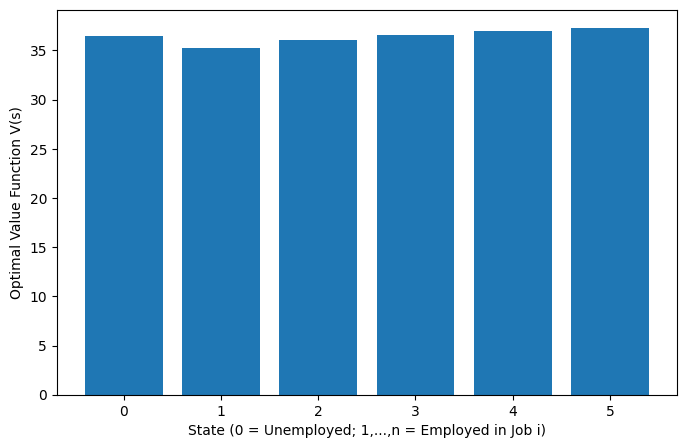

In [3]:
n = 5
wages = [20, 30, 40, 50, 60]
probs = [0.2, 0.2, 0.2, 0.2, 0.2]
alpha = 0.5
gamma = 0.9
w0 = 15

V, policy = solve_mdp(n, wages, probs, alpha, gamma, w0)

print("Optimal Value Function:")
for s in sorted(V.keys()):
    if s == 0:
        print(f"State Unemployed (0): {V[s]:.4f}")
    else:
        print(f"State Employed in job {s}: {V[s]:.4f}")

print("\nOptimal Policy for Unemployed State (for each job offer):")
for i in range(1, n+1):
    print(f"Job offer {i} (wage {wages[i-1]}): {policy[i]}")

# visualization
states = list(sorted(V.keys()))
values = [V[s] for s in states]

plt.figure(figsize=(8, 5))
plt.bar([str(s) for s in states], values)
plt.xlabel("State (0 = Unemployed; 1,...,n = Employed in Job i)")
plt.ylabel("Optimal Value Function V(s)")
plt.show()

### Part (D) Answer

- n represents how many options workers can have in each day. Among n jobs, workers tend to accept jobs that offer wages that much higher than unemployment wage and tend to decline jobs that offer wages aound or lower than  unemployment wage.
- When alpha increases, worker are more likely to lose their job, making the future be more unstable. Therefore, value function for state 0 (unemployed) increase; value function for other states (employed) decrease; and workers tend to accept job with relatively low salary.
-  Higher gamma means that the worker places more weight on future wages. This increases the value of holding a good job.
In general, in this casem unemployed workers compare the immediate benefit of taking a job (with its risk of loss and lower salary comparing other job) versus the option of staying unemployed but waiting for other high salary job. With higher value of gamma and alpha, workers tend to keep the current job.

In [68]:
# with more n
n = 20
wages = [20 + 10 * i for i in range(n)] 
probs = [1 / n] * n 
alpha = 0.5
gamma = 0.9
w0 = 10

V, policy = solve_mdp(n, wages, probs, alpha, gamma, w0)

print("Optimal Value Function:")
for s in sorted(V.keys()):
    if s == 0:
        print(f"State Unemployed (0): {V[s]}")
    else:
        print(f"State Employed in job {s}: {V[s]}")

print("\nOptimal Policy for Unemployed State (for each job offer):")
for i in range(1, n+1):
    print(f"Job offer {i} (wage {wages[i-1]}): {policy[i]}")

147
Optimal Value Function:
State Unemployed (0): 45.883638581769915
State Employed in job 1: 42.98794322366994
State Employed in job 2: 43.725152511139335
State Employed in job 3: 44.24821082468802
State Employed in job 4: 44.653926372532034
State Employed in job 5: 44.985420112157406
State Employed in job 6: 45.26569407547969
State Employed in job 7: 45.5084784257061
State Employed in job 8: 45.722629399626804
State Employed in job 9: 45.91419397355012
State Employed in job 10: 46.08748520955798
State Employed in job 11: 46.24568771317549
State Employed in job 12: 46.39121990894555
State Employed in job 13: 46.52596167649778
State Employed in job 14: 46.6514032610195
State Employed in job 15: 46.76874602672418
State Employed in job 16: 46.87897261184498
State Employed in job 17: 46.98289700064489
State Employed in job 18: 47.08120103931811
State Employed in job 19: 47.1744615745682
State Employed in job 20: 47.26317096396716

Optimal Policy for Unemployed State (for each job offer):


In [67]:
# with varied alpha
n = 5
wages = [20 + 10 * i for i in range(n)] 
probs = [1 / n] * n 
alpha = 0.2
gamma = 0.9
w0 = 10

V, policy = solve_mdp(n, wages, probs, alpha, gamma, w0)

print("Optimal Value Function:")
for s in sorted(V.keys()):
    if s == 0:
        print(f"State Unemployed (0): {V[s]}")
    else:
        print(f"State Employed in job {s}: {V[s]}")

print("\nOptimal Policy for Unemployed State (for each job offer):")
for i in range(1, n+1):
    print(f"Job offer {i} (wage {wages[i-1]}): {policy[i]}")

145
Optimal Value Function:
State Unemployed (0): 36.77842186755469
State Employed in job 1: 34.342311972149496
State Employed in job 2: 35.790401643964366
State Employed in job 3: 36.81783761700645
State Employed in job 4: 37.61477887170004
State Employed in job 5: 38.2659272888213

Optimal Policy for Unemployed State (for each job offer):
Job offer 1 (wage 20): reject
Job offer 2 (wage 30): accept
Job offer 3 (wage 40): accept
Job offer 4 (wage 50): accept
Job offer 5 (wage 60): accept


In [66]:
# with varied alpha
n = 5
wages = [20 + 10 * i for i in range(n)] 
probs = [1 / n] * n 
alpha = 0.8
gamma = 0.9
w0 = 10

V, policy = solve_mdp(n, wages, probs, alpha, gamma, w0)

print("Optimal Value Function:")
for s in sorted(V.keys()):
    if s == 0:
        print(f"State Unemployed (0): {V[s]}")
    else:
        print(f"State Employed in job {s}: {V[s]}")

print("\nOptimal Policy for Unemployed State (for each job offer):")
for i in range(1, n+1):
    print(f"Job offer {i} (wage {wages[i-1]}): {policy[i]}")

145
Optimal Value Function:
State Unemployed (0): 36.18434496545343
State Employed in job 1: 35.42495098759724
State Employed in job 2: 35.91942063163159
State Employed in job 3: 36.27025242730449
State Employed in job 4: 36.54237870939499
State Employed in job 5: 36.76472207133883

Optimal Policy for Unemployed State (for each job offer):
Job offer 1 (wage 20): accept
Job offer 2 (wage 30): accept
Job offer 3 (wage 40): accept
Job offer 4 (wage 50): accept
Job offer 5 (wage 60): accept


In [74]:
# with varied gamma
n = 5
wages = [20 + 10 * i for i in range(n)] 
probs = [1 / n] * n 
alpha = 0.8
gamma = 0.8
w0 = 10

V, policy = solve_mdp(n, wages, probs, alpha, gamma, w0)

print("Optimal Value Function:")
for s in sorted(V.keys()):
    if s == 0:
        print(f"State Unemployed (0): {V[s]}")
    else:
        print(f"State Employed in job {s}: {V[s]}")

print("\nOptimal Policy for Unemployed State (for each job offer):")
for i in range(1, n+1):
    print(f"Job offer {i} (wage {wages[i-1]}): {policy[i]}")

69
Optimal Value Function:
State Unemployed (0): 18.092172955635437
State Employed in job 1: 17.350859786775825
State Employed in job 2: 17.833556344047448
State Employed in job 3: 18.17603500172814
State Employed in job 4: 18.441682086626006
State Employed in job 5: 18.658731558999765

Optimal Policy for Unemployed State (for each job offer):
Job offer 1 (wage 20): accept
Job offer 2 (wage 30): accept
Job offer 3 (wage 40): accept
Job offer 4 (wage 50): accept
Job offer 5 (wage 60): accept


## Question 2: Two-Stores Inventory Control (Led by Yuteng, James)

We extend the capacity-constrained inventory example implemented in [rl/chapter3/simple_inventory_mdp_cap.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter3/simple_inventory_mdp_cap.py) as a `FiniteMarkovDecisionProcess` (the Finite MDP model for the capacity-constrained inventory example is described in detail in Chapters 1 and 2 of the RLForFinanceBook). Here we assume that we have two different stores, each with their own separate capacities $C_1$ and $C_2$, their own separate Poisson probability distributions of demand (with means $\lambda_1$ and $\lambda_2$), their own separate holding costs $h_1$ and $h_2$, and their own separate stockout costs $p_1$ and $p_2$. At 6pm upon stores closing each evening, each store can choose to order inventory from a common supplier (as usual, ordered inventory will arrive at the store 36 hours later). We are also allowed to transfer inventory from one store to another, and any such transfer happens overnight, i.e., will arrive by 6am next morning (since the stores are fairly close to each other). Note that the orders are constrained such that following the orders on each evening, each store's inventory position (sum of on-hand inventory and on-order inventory) cannot exceed the store's capacity (this means the action space is constrained to be finite). Each order made to the supplier incurs a fixed transportation cost of $K_1$ (fixed-cost means the cost is the same no matter how many units of non-zero inventory a particular store orders). Moving any non-zero inventory between the two stores incurs a fixed transportation cost of $K_2$. 

Model this as a derived class of `FiniteMarkovDecisionProcess` much like we did for `SimpleInventoryMDPCap` in the code repo. Set up instances of this derived class for different choices of the problem parameters (capacities, costs etc.), and determine the Optimal Value Function and Optimal Policy by invoking the function `value_iteration` (or `policy_iteration`) from file [rl/dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/dynamic_programming.py).

Analyze the obtained Optimal Policy and verify that it makes intuitive sense as a function of the problem parameters.

In [2]:
@dataclass(frozen=True)
class InventoryState:
    on_hand: int
    on_order: int

    def inventory_position(self) -> int:
        return self.on_hand + self.on_order

# Modified
# Define combined states for 2-store case
@dataclass(frozen=True)
class TwoStoreState:
    store1: InventoryState
    store2: InventoryState

# An action is a triple: (order1, order2, transfer) where transfer > 0 means store1 sends to store2,
Action = Tuple[int, int, int]

TwoStoreInvMapping = Mapping[TwoStoreState, Mapping[Action, Categorical[Tuple[TwoStoreState, float]]]]

class TwoStoreInventoryMDP(FiniteMarkovDecisionProcess[TwoStoreState, Action]):
    def __init__(
        self,
        capacity1: int,
        capacity2: int,
        lambda1: float,
        lambda2: float,
        holding_cost1: float,
        holding_cost2: float,
        stockout_cost1: float,
        stockout_cost2: float,
        ordering_cost: float,
        transfer_cost: float
    ):
        self.capacity1 = capacity1
        self.capacity2 = capacity2
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.holding_cost1 = holding_cost1
        self.holding_cost2 = holding_cost2
        self.stockout_cost1 = stockout_cost1
        self.stockout_cost2 = stockout_cost2
        self.ordering_cost = ordering_cost
        self.transfer_cost = transfer_cost
        
        self.poisson1 = poisson(lambda1)
        self.poisson2 = poisson(lambda2)
        
        mapping = self.get_action_transition_reward_map()
        super().__init__(mapping)
    
    def get_action_transition_reward_map(self) -> TwoStoreInvMapping:
        mapping: Dict[TwoStoreState, Dict[Action, Categorical[Tuple[TwoStoreState, float]]]] = {}
        
        # Enumerate all feasible states for each store:
        # For store i, on_hand range from 0 to capacity_i; and on_order range from  0. to (capacity_i - on_hand)
        states1 = [InventoryState(a, b)
                   for a in range(self.capacity1 + 1)
                   for b in range(self.capacity1 - a + 1)]
        states2 = [InventoryState(a, b)
                   for a in range(self.capacity2 + 1)
                   for b in range(self.capacity2 - a + 1)]
        
        # Iterate over all combined states
        for s1 in states1:
            for s2 in states2:
                state = TwoStoreState(s1, s2)
                action_map: Dict[Action, Categorical[Tuple[TwoStoreState, float]]] = {}
                
                # Determine feasible transfers
                # x can range from -s2.on_hand to s1.on_hand
                for x in range(-s2.on_hand, s1.on_hand + 1):
                    # After transfer, new on-hand for each store
                    new_on_hand1 = s1.on_hand - x
                    new_on_hand2 = s2.on_hand + x

                    if new_on_hand1 < 0 or new_on_hand2 < 0:
                        continue
                    # Inventory positions before ordering
                    ip1 = new_on_hand1 + s1.on_order
                    ip2 = new_on_hand2 + s2.on_order
                    # Feasible orders
                    # Iterate over two orders
                    for order1 in range(self.capacity1 - ip1 + 1):
                        for order2 in range(self.capacity2 - ip2 + 1):
                            action: Action = (order1, order2, x)
                            # Fixed cost
                            fixed_cost = 0.0
                            if order1 > 0:
                                fixed_cost += self.ordering_cost
                            if order2 > 0:
                                fixed_cost += self.ordering_cost
                            if x != 0:
                                fixed_cost += self.transfer_cost
                            
                            # For store1 calculate the outcome distribution
                            new_ip1 = ip1
                            base_reward1 = - self.holding_cost1 * new_on_hand1
                            outcomes1: Dict[Tuple[InventoryState, float], float] = {}
                            # For demands d from 0 to (new_ip1 - 1)
                            for d in range(new_ip1):
                                next_state1 = InventoryState(new_ip1 - d, order1)
                                outcomes1[(next_state1, base_reward1)] = self.poisson1.pmf(d)
                            # For d >= new_ip1
                            tail1 = 1 - self.poisson1.cdf(new_ip1 - 1)
                            if tail1 > 0:
                                penalty1 = self.stockout_cost1 * (self.lambda1 - new_ip1 * (1 - self.poisson1.pmf(new_ip1)/tail1))
                                next_state1 = InventoryState(0, order1)
                                outcomes1[(next_state1, base_reward1 - penalty1)] = tail1
                            
                            # For store2 calculate the outcome distribution too
                            new_ip2 = ip2
                            base_reward2 = - self.holding_cost2 * new_on_hand2
                            outcomes2: Dict[Tuple[InventoryState, float], float] = {}
                            # For demands d from 0 to (new_ip2 - 1)
                            for d in range(new_ip2):
                                next_state2 = InventoryState(new_ip2 - d, order2)
                                outcomes2[(next_state2, base_reward2)] = self.poisson2.pmf(d)
                            # For d >= new_ip1
                            tail2 = 1 - self.poisson2.cdf(new_ip2 - 1)
                            if tail2 > 0:
                                penalty2 = self.stockout_cost2 * (self.lambda2 - new_ip2 * (1 - self.poisson2.pmf(new_ip2)/tail2))
                                next_state2 = InventoryState(0, order2)
                                outcomes2[(next_state2, base_reward2 - penalty2)] = tail2
                            
                            # Defined the joint ourcomes (Combination of outcome1 & outcome2)
                            sr_probs_dict: Dict[Tuple[TwoStoreState, float], float] = {}
                            for ((next_s1, r1), p1) in outcomes1.items():
                                for ((next_s2, r2), p2) in outcomes2.items():
                                    next_state = TwoStoreState(next_s1, next_s2)
                                    # Total reward calculation
                                    total_reward = r1 + r2 - fixed_cost
                                    sr_probs_dict[(next_state, total_reward)] = p1 * p2
                            
                            action_map[action] = Categorical(sr_probs_dict)
                mapping[state] = action_map
        return mapping

In [9]:
capacity1 = 3
capacity2 = 3 
lambda1 = 2.0
lambda2 = 2.0 
holding_cost1 = 1.0
holding_cost2 = 1.0
stockout_cost1 = 5.0
stockout_cost2 = 5.0
ordering_cost = 10.0
transfer_cost = 0.5
gamma = 0.9

mdp = TwoStoreInventoryMDP(
    capacity1=capacity1,
    capacity2=capacity2,
    lambda1=lambda1,
    lambda2=lambda2,
    holding_cost1=holding_cost1,
    holding_cost2=holding_cost2,
    stockout_cost1=stockout_cost1,
    stockout_cost2=stockout_cost2,
    ordering_cost=ordering_cost,
    transfer_cost=transfer_cost
)

optimal_vf, optimal_policy = policy_iteration_result(mdp, gamma)

print("Optimal Value Function:")
for state, value in optimal_vf.items():
    print(f"State {state}: Value = {value:.2f}")

print("\nOptimal Deterministic Policy:")

for state, action in optimal_policy.policy_map.items():
    print(f"State {state} -> Action {action}")


Optimal Value Function:
State NonTerminal(state=TwoStoreState(store1=InventoryState(on_hand=0, on_order=0), store2=InventoryState(on_hand=0, on_order=0))): Value = -188.92
State NonTerminal(state=TwoStoreState(store1=InventoryState(on_hand=0, on_order=0), store2=InventoryState(on_hand=0, on_order=1))): Value = -184.78
State NonTerminal(state=TwoStoreState(store1=InventoryState(on_hand=0, on_order=0), store2=InventoryState(on_hand=0, on_order=2))): Value = -180.65
State NonTerminal(state=TwoStoreState(store1=InventoryState(on_hand=0, on_order=0), store2=InventoryState(on_hand=0, on_order=3))): Value = -177.21
State NonTerminal(state=TwoStoreState(store1=InventoryState(on_hand=0, on_order=0), store2=InventoryState(on_hand=1, on_order=0))): Value = -185.78
State NonTerminal(state=TwoStoreState(store1=InventoryState(on_hand=0, on_order=0), store2=InventoryState(on_hand=1, on_order=1))): Value = -181.65
State NonTerminal(state=TwoStoreState(store1=InventoryState(on_hand=0, on_order=0), stor

If $onhand + onorder$ much less than capacity, two stores tend to order a lot (3 in our cases). If $onhand + onorder$ close to capacity, considering shipping cost, store tend to not order.  
Transfer only happens when one stock is nearly stockout but the other store's stock is almost full.

## Question 3: Dynamic Price Optimization (Led by Yuteng, James)

You own a supermarket, and you are $T$ days away from Halloween 🎃. You have just received $M$ Halloween masks from your supplier. You want to dynamically set the selling price of the Halloween masks at the start of each day in a manner that maximizes your **Expected Total Sales Revenue** for Halloween masks this season (assume no one will buy Halloween masks after Halloween).

Assume that for each of the $T$ days, you are required to select a price for that day from one of $N$ prices $p_1, p_2, \dots, p_N \in \mathbb{R}$, and that price is the selling price for all masks on that day. Assume that the customer demand for the number of Halloween masks on any day is governed by a Poisson probability distribution with mean $\lambda_i \in \mathbb{R}$ if you select that day’s price to be $p_i$ (where $i$ is a choice among $1, 2, \dots, N$).

Note that on any given day, the demand could exceed the number of Halloween masks you have in the store, in which case the number of masks sold on that day will be equal to the number of Halloween masks you had at the start of that day.

We spoke about this example in class - referencing the slides here (if needed) could be helpful!

---

### Subquestions

#### Part (A): Bellman Optimality Equation

Write the **Bellman Optimality Equation** customized to this Markov Decision Process (MDP). Essentially, you need to express the **Optimal Value Function** $v_*$ recursively based on taking the best action in the current state and based on the subsequent random customer demand that would produce the appropriate reward and take you to the next state.

**Note**: The probability mass function of a Poisson distribution with mean $\lambda \in \mathbb{R}$ is given by:

$$
f(k) = \frac{e^{-\lambda} \lambda^k}{k!}, \quad k = 0, 1, 2, \dots
$$

---

#### Part (B): Boundary Conditions

To be able to solve the $v_*$ recursion, you need to know the values of $v_*$ for the boundary case (boundary states). Write down the boundary case(s) for the $v_*$ recursion.

---

#### Part (C): Numerical Solution

You can solve this $v_*$ recursion (hence, solve for the **Optimal Policy** $\pi_*$) with a numerical recursive algorithm (essentially a special form of Dynamic Programming algorithm customized to this problem). 

Write Python code for this algorithm that would enable you to dynamically set the selling price at the start of each day. Clearly define the inputs and outputs of your algorithm with their types (`int`, `float`, `List`, `Mapping`, etc.).

---


### Part (A) Answer

- $m$: Number of masks available at the start of a day.
- $t$: Number of days remaining until Halloween.
- $p_i$: Candidate selling prices, where \( i = 1, \dots, N \).
- $\lambda_i$: Mean demand if price \( p_i \) is chosen.
- $f_i(k)$: Probability that the demand is exactly \( k \), given by:
$$
v^*(m, t) = \max_{i=1, \dots, N} \sum_{k=0}^\infty f_i(k) \left[ p_i \cdot \min\{m, k\} + v^*\left(m - \min\{m, k\}, t - 1 \right) \right].
$$

### Part (B) Answer

There are two boundary case:
$$
v^*(m,0)=0
$$
$$
v^*(0,T)=0
$$

### Part (C) Answer

In [12]:
def poisson_pmf(k: int, lam: float) -> float:
    return math.exp(-lam) * (lam ** k) / math.factorial(k)

def solve_dynamic_pricing(
    T: int,                   # Total number of days remaining
    M: int,                   # Initial inventory
    prices: List[float],      # List of possible prices
    lambdas: List[float],     # List of mean demands corresponding to each price
    truncation: int = 100     # Truncation number for Poisson distribution
) -> Tuple[Dict[Tuple[int, int], float], Dict[Tuple[int, int], int]]:
    # optimal value function
    V: Dict[Tuple[int, int], float] = {}
    # policy[(m,t)] will store the index of the optimal price choice.
    policy: Dict[Tuple[int, int], int] = {}
    
    # Boundary condition
    for m in range(M + 1):
        V[(m, 0)] = 0.0
    for t in range(T + 1):
        V[(0, t)] = 0.0
    
    # Iteration for each state (m,t)
    for t in range(1, T + 1):
        for m in range(1, M + 1):
            best_value = -float('inf')
            best_action = None
            
            # Evaluate each pricing option
            for i, (p_i, lam_i) in enumerate(zip(prices, lambdas)):
                expected_value = 0.0
                # Sum over all possible demand
                # Use truncation to simplify poisson process
                for k in range(truncation + 1):
                    # Current reward
                    prob = poisson_pmf(k, lam_i)
                    sold = min(m, k)
                    immediate_revenue = p_i * sold
                    # Next state: remaining masks = m - sold, with t-1 days left
                    future_value = V[(m - sold, t - 1)]
                    expected_value += prob * (immediate_revenue + future_value)
                # Update best action if this price yields a higher expected revenue
                if expected_value > best_value:
                    best_value = expected_value
                    best_action = i
                    
            V[(m, t)] = best_value
            policy[(m, t)] = best_action
            
    return V, policy

In [13]:
T = 10
M = 50
prices = [10.0, 12.0, 15.0]
lambdas = [30.0, 20.0, 10.0]

V, optimal_policy = solve_dynamic_pricing(T, M, prices, lambdas, truncation=100)

print("Optimal Expected Revenue:")
for t in range(T + 1):
    print(f"Days remaining = {t}:")
    for m in range(0, M+1, 10):
        value = V[(m, t)]
        print(f"  Inventory {m}: {value:.2f}")

print("\nOptimal Price Decisions (showing price index for state (m,t)):")
for t in range(1, T + 1):
    print(f"Days remaining = {t}:")
    for m in range(10, M+1, 10):
        price_index = optimal_policy[(m, t)]
        price = prices[price_index]
        print(f"  Inventory {m}: Choose price = {price} (index {price_index})")


Optimal Expected Revenue:
Days remaining = 0:
  Inventory 0: 0.00
  Inventory 10: 0.00
  Inventory 20: 0.00
  Inventory 30: 0.00
  Inventory 40: 0.00
  Inventory 50: 0.00
Days remaining = 1:
  Inventory 0: 0.00
  Inventory 10: 131.23
  Inventory 20: 218.68
  Inventory 30: 278.21
  Inventory 40: 299.05
  Inventory 50: 299.99
Days remaining = 2:
  Inventory 0: 0.00
  Inventory 10: 149.88
  Inventory 20: 277.92
  Inventory 30: 366.15
  Inventory 40: 453.29
  Inventory 50: 512.79
Days remaining = 3:
  Inventory 0: 0.00
  Inventory 10: 150.00
  Inventory 20: 299.27
  Inventory 30: 426.05
  Inventory 40: 518.30
  Inventory 50: 608.33
Days remaining = 4:
  Inventory 0: 0.00
  Inventory 10: 150.00
  Inventory 20: 300.00
  Inventory 30: 448.32
  Inventory 40: 574.13
  Inventory 50: 668.41
Days remaining = 5:
  Inventory 0: 0.00
  Inventory 10: 150.00
  Inventory 20: 300.00
  Inventory 30: 449.97
  Inventory 40: 597.26
  Inventory 50: 722.34
Days remaining = 6:
  Inventory 0: 0.00
  Inventory 10

## Question 4: Risk-Aversion and Utility Optimization under CARA Utility (Led by Yuteng, James)

You are tasked with analyzing the behavior of an investor who seeks to maximize their utility under **CARA Utility**. The investor has wealth $W$ and the CARA utility function:

$$
U(W) = \frac{1 - e^{-aW}}{a}, \quad a > 0,
$$

where $a$ represents the investor's **risk aversion**.

The investor allocates their wealth between:
1. A **riskless asset** with a fixed return $r$, and
2. A **risky asset** with return $R \sim \mathcal{N}(\mu, \sigma^2)$

The investor allocates a fraction $\pi$ of their wealth to the risky asset and $(1 - \pi)$ to the riskless asset. The wealth $W$ after one year is given by:

$$
W = (1 + r)(1 - \pi) + (1 + R)\pi.
$$

The goal is to analyze the investor’s optimal allocation $\pi$ to the risky asset and compute key risk-related quantities.

---

### Subquestions

#### Part (A): Expected Utility and Certainty-Equivalent Wealth

1. Derive the expression for the **expected utility** $\mathbb{E}[U(W)]$, using the given CARA utility function and assuming $R \sim \mathcal{N}(\mu, \sigma^2)$.
2. Using a Taylor expansion, approximate the **certainty-equivalent wealth** $W_{CE}$ up to second-order terms.

---

#### Part (B): Optimal Portfolio Allocation

Derive the optimal fraction $\pi^*$ of wealth to be allocated to the risky asset such that the **expected utility** $\mathbb{E}[U(W)]$ is maximized. Express $\pi^*$ in terms of $a$, $\mu$, $r$, and $\sigma^2$.

---

#### Part (C): Risk Premium

1. Using the results from Part (A), calculate the **absolute risk premium** $\pi_A = \mathbb{E}[W] - W_{CE}$.
2. Verify that $\pi_A \approx \frac{a \pi^2 \sigma^2}{2}$ for small $\sigma^2$.

---

#### Part (D): Numerical Calculations and Interpretation

Given the parameters $r = 0.02$, $\mu = 0.08$, $\sigma^2 = 0.04$, and $a = 3$:
1. Compute the optimal allocation $\pi^*$.
2. Calculate the certainty-equivalent wealth $W_{CE}$.
3. Compute the absolute risk premium $\pi_A$.
4. Interpret the results and discuss how changes in $a$ and $\sigma^2$ affect the risk premium and portfolio allocation.

---

#### Part (E): Expected Utility under Uniform Distribution

Now assume that the return of the risky asset, $R$, is no longer normally distributed. Instead, $R \sim \text{Uniform}[\alpha, \beta]$, where $\alpha$ and $\beta$ are the lower and upper bounds of the distribution, respectively.

1. Derive the new expression for the **expected utility** $\mathbb{E}[U(W)]$. Make sure to simplify your result as much as possible, and ensure that it explicitly depends on $a$, $\pi$, $\alpha$, $\beta$, and $r$.

**Hint**: Use the fact that if $W \sim \text{Uniform}[w_{\text{min}}, w_{\text{max}}]$, then:

$$
\mathbb{E}[g(W)] = \frac{1}{w_{\text{max}} - w_{\text{min}}} \int_{w_{\text{min}}}^{w_{\text{max}}} g(W) \, dW.
$$

---

### Part (A) Answer
First, write the expected utility:
$$
\[
\mathbb{E}[U(W)] = \frac{1}{a}\Bigl(1-\mathbb{E}\bigl[e^{-aW}\bigr]\Bigr).
\]
$$
Since
$$
\[
W= 1+r+\pi\,(R-r),
\]$$

we have
$$\[
e^{-aW} = e^{-a(1+r)}\;e^{-a\pi\,(R-r)}.
\]$$
For $\(R\sim\mathcal{N}(\mu,\sigma^2)\)$ the moment‐generating function is available, and hence
$$\[
\mathbb{E}\left[e^{-a\pi\,(R-r)}\right]
=\exp\Bigl[-a\pi(\mu-r)+\tfrac{1}{2}(a\pi)^2\sigma^2\Bigr].
\]$$
Thus,
$$\[
\mathbb{E}\bigl[e^{-aW}\bigr] = \exp\Bigl[-a\Bigl(1+r+\pi(\mu-r)\Bigr)+\frac{1}{2}a^2\pi^2\sigma^2\Bigr],
\]$$
and so
$$\[
\mathbb{E}[U(W)] = \frac{1}{a}\left\{1-\exp\Bigl[-a\Bigl(1+r+\pi(\mu-r)\Bigr)+\frac{1}{2}a^2\pi^2\sigma^2\Bigr]\right\}.
\]$$

The certainty‐equivalent \(W_{CE}\) is defined by
$$
\[
U(W_{CE}) = \mathbb{E}[U(W)]\quad\Longleftrightarrow\quad \frac{1-e^{-aW_{CE}}}{a} = \frac{1-\mathbb{E}\bigl[e^{-aW}\bigr]}{a}.
\]
$$
Thus,
$$\[
e^{-aW_{CE}} = \mathbb{E}\bigl[e^{-aW}\bigr]
=\exp\Bigl[-a\Bigl(1+r+\pi(\mu-r)\Bigr)+\frac{1}{2}a^2\pi^2\sigma^2\Bigr].
\]$$
Taking logs we immediately obtain
$$\[
W_{CE} = 1+r+\pi(\mu-r)-\frac{a\pi^2\sigma^2}{2}.
\]$$
In fact, this agrees with the standard second‐order expansion:
$$\[
W_{CE}\approx \mathbb{E}[W] - \frac{a}{2} * Var(W)
\]$$
since $\(\mathbb{E}[W]=1+r+\pi(\mu-r)\)$ and $\(Var(W)=\pi^2\sigma^2\)$.

Thus, the answer is
$$\[
W_{CE} = 1+r+\pi(\mu-r)-\frac{a\pi^2\sigma^2}{2}\,.
\]$$


### Part (B) Answer
We choose $\(\pi\)$ to maximize $\(\mathbb{E}[U(W)]\)$. Since the utility is monotone in the exponent we may equivalently maximize
$$\[
-a\Bigl(1+r+\pi(\mu-r)\Bigr)+\frac{1}{2}a^2\pi^2\sigma^2.
\]$$
Taking the derivative with respect to \(\pi\) and setting it equal to zero gives
$$\[
\frac{d}{d\pi}\Biggl[-a(1+r+\pi(\mu-r))+\frac{1}{2}a^2\pi^2\sigma^2\Biggr]
=-a(\mu-r)+a^2\pi\sigma^2=0.
\]$$
Thus,
$$\[
a^2\pi\sigma^2 = a(\mu-r)
\]$$
and hence
$$\[
\pi^* = \frac{\mu-r}{a\sigma^2}\,
\]$$

### Part (C) Answer

The absolute risk premium is defined as the difference between the expected wealth and the certainty‐equivalent wealth:
$$\[
\pi_A = \mathbb{E}[W]-W_{CE}.
\]$$
Recall that
$$\[
\mathbb{E}[W]=1+r+\pi(\mu-r)
\]$$
and
$$\[
W_{CE}=1+r+\pi(\mu-r)-\frac{a\pi^2\sigma^2}{2}\,
\]$$
Thus,
$$\[
\pi_A = \frac{a\pi^2\sigma^2}{2}\,
\]$$
For small $\(\sigma^2\)$ (or small a or $\(\pi\)$) the approximation is exact up to the second order. That is,
$$\[
\pi_A \approx \frac{a\pi^2\sigma^2}{2}\,.
\]$$

### Part (D) Answer

1. 
$$
   \[
   \pi^* = \frac{\mu-r}{a\sigma^2} = \frac{0.08-0.02}{3\cdot0.04}=\frac{0.06}{0.12}=0.5.
   \]$$
   Thus, the investor puts 50% of wealth in the risky asset.

2. 

   First, compute the expected wealth:
   $$\[
   \mathbb{E}[W]=1+r+\pi(\mu-r)=1+0.02+0.5\,(0.08-0.02)=1.02+0.03=1.05.
   \]$$
   Then,
   $$\[
   W_{CE} = 1.05 - \frac{a\pi^2\sigma^2}{2}
   = 1.05-\frac{3\,(0.5)^2\,(0.04)}{2}
   = 1.05-\frac{3\cdot0.25\cdot0.04}{2}
   = 1.05-\frac{0.03}{2}
   = 1.05-0.015=1.035.
   \]$$

3.
   $$\[
   \pi_A = \mathbb{E}[W]-W_{CE} = 1.05-1.035=0.015.
   \]$$

4. 
   - With $\(a=3\)$, the investor is moderately risk‐averse; the optimal allocation $\(\pi^*=\frac{\mu-r}{a\sigma^2}\)$ shows that a higher risk aversion $(larger \(a\))$ or higher variance $\(\sigma^2\)$ lowers the fraction allocated to the risky asset.
   - The certainty‐equivalent wealth $\(W_{CE}\)$ is less than the expected wealth by the risk premium $\(\pi_A\)$, which here is 1.5% of wealth.
   - If either the risk aversion parameter $\(a\)$ or the variance $\(\sigma^2\)$ increases, the penalty term $\(\frac{a\pi^2\sigma^2}{2}\)$ becomes larger, reducing $\(W_{CE}\)$ (i.e. the investor would require a larger compensation for taking on risk), and the optimal risky share $\(\pi^*\)$ would be lower.


### Part (E) Answer

Then the final wealth is still given by
$$\[
W = (1+r)(1-\pi) + (1+R)\pi.
\]$$
Thus, when $\(R\)$ varies uniformly, so does $\(W\)$. In fact, the minimum and maximum wealth are:
$$\[
w_{\min} = (1+r)(1-\pi) + (1+\alpha)\pi,\qquad w_{\max} = (1+r)(1-\pi) + (1+\beta)\pi.
\]$$
The width of the distribution is
$$\[
w_{\max}-w_{\min} = \pi[(1+\beta)-(1+\alpha)] = \pi(\beta-\alpha).
\]$$

The expected utility is given by
$$\[
\mathbb{E}[U(W)] = \frac{1}{w_{\max}-w_{\min}} \int_{w_{\min}}^{w_{\max}} \frac{1-e^{-aW}}{a}\,dW
=\frac{1}{a\,\pi(\beta-\alpha)}\int_{w_{\min}}^{w_{\max}}\left(1-e^{-aW}\right)dW.
\]$$

We now perform the integration. Note that
$$\[
\int \left(1-e^{-aW}\right)dW = W + \frac{e^{-aW}}{a}+C,
\]$$
since
$$\[
\frac{d}{dW}\Bigl(W + \frac{e^{-aW}}{a}\Bigr)= 1 - e^{-aW}.
\]$$
Thus,
$$\[
\int_{w_{\min}}^{w_{\max}}\left(1-e^{-aW}\right)dW 
=\left[W + \frac{e^{-aW}}{a}\right]_{w_{\min}}^{w_{\max}}
=\left(w_{\max}-w_{\min}\right) + \frac{e^{-aw_{\max}}-e^{-aw_{\min}}}{a}.
\]$$
Then
$$\[
\mathbb{E}[U(W)] = \frac{1}{a\,\pi(\beta-\alpha)}\left\{\pi(\beta-\alpha) + \frac{e^{-aw_{\max}}-e^{-aw_{\min}}}{a}\right\}
=\frac{1}{a}\left\{1 + \frac{e^{-aw_{\max}}-e^{-aw_{\min}}}{a\,\pi(\beta-\alpha)}\right\}.
\]$$

Recalling that
$$\[
w_{\min} = (1+r)(1-\pi) + (1+\alpha)\pi,\quad
w_{\max} = (1+r)(1-\pi) + (1+\beta)\pi,
\]$$
we have the final answer:
$$\[

\mathbb{E}[U(W)] = \frac{1}{a}\left\{1 + \frac{e^{-a[(1+r)(1-\pi)+(1+\beta)\pi]}-e^{-a[(1+r)(1-\pi)+(1+\alpha)\pi]}}{a\,\pi(\beta-\alpha)}\right\}\,.

\]$$

## Question 5: Feeding Animals in a Zoo using Approximate Dynamic Programming (Led by Yuteng, James)

You are tasked with developing a feeding strategy for a zoo using **Approximate Dynamic Programming (ADP)**. The zoo has a finite amount of food available each day, and you must distribute this food among a group of animals to maximize their overall satisfaction over a fixed time horizon $T$. 

Each animal has:
1. A **hunger level** $h_i(t) \in \mathbb{R}$ at time $t$, which increases as time passes without food and decreases when food is provided.
2. A **satisfaction function** $u_i(f) = \log(1 + f)$, where $f$ is the amount of food given to the animal. Satisfaction increases logarithmically with food.

You start each day with a total amount of food $F$ that you can distribute to the animals. The objective is to maximize the **cumulative satisfaction** of all animals over $T$ days while considering that food is finite and hunger levels evolve dynamically.

---

### Problem Dynamics:
1. **State**:
   - The state at time $t$ is the vector of hunger levels of all animals: $\mathbf{h}(t) = [h_1(t), h_2(t), \dots, h_N(t)]$, where $N$ is the number of animals.

2. **Action**:
   - The action $\mathbf{f}(t) = [f_1(t), f_2(t), \dots, f_N(t)]$ represents the food allocated to each animal, subject to the constraint:
     $$
     \sum_{i=1}^N f_i(t) \leq F.
     $$

3. **State Transition**:
   - Hunger levels evolve according to the dynamics:
     $$
     h_i(t+1) = \max(0, h_i(t) + \gamma - \delta f_i(t)),
     $$
     where $\gamma$ is the natural rate at which an animal's hunger increases, and $\delta$ is the rate at which feeding reduces hunger.

4. **Reward**:
   - The reward at each time step is the total satisfaction of all animals:
     $$
     r(\mathbf{h}(t), \mathbf{f}(t)) = \sum_{i=1}^N \log(1 + f_i(t)).
     $$

5. **Value Function Approximation**:
   - Use a **linear function approximation** for the value function:
     $$
     V(\mathbf{h}(t); \mathbf{w}) = \mathbf{w}^\top \phi(\mathbf{h}(t)),
     $$
     where $\phi(\mathbf{h}(t))$ is a feature vector derived from the state, and $\mathbf{w}$ is a weight vector learned during training.

6. **Objective**:
   - Use **Approximate Dynamic Programming (ADP)** to iteratively update the weights $\mathbf{w}$ and maximize the total cumulative reward:
     $$
     \max \ \mathbb{E} \left[\sum_{t=0}^{T-1} r(\mathbf{h}(t), \mathbf{f}(t)) \right].
     $$

---

### Subquestions

#### Part (A): State Representation
Write down the state vector $\mathbf{h}(t)$ and describe how it evolves over time based on the dynamics provided above.

---

#### Part (B): Reward Function
Derive the formula for the reward function $r(\mathbf{h}(t), \mathbf{f}(t))$ explicitly for $N=3$ animals. Assume specific food allocations $\mathbf{f}(t) = [f_1, f_2, f_3]$.

---

#### Part (C): Linear Function Approximation
Explain how the value function $V(\mathbf{h}(t))$ is approximated using the feature vector $\phi(\mathbf{h}(t))$ and the weight vector $\mathbf{w}$. Discuss why feature normalization is essential in this problem. What would happen if we didn't normalize the features?

---

#### Part (D): Numerical Simulation
Using the provided starter code, fill in all `TODO` areas. This will allow you to train the ADP model and compute the following:
1. The convergence of weights $\mathbf{w}$ over episodes.
2. The hunger levels of each animal over the time horizon $T$.
3. The total utility (cumulative reward) achieved over time for all animals.

**Hint**: What does the weight update formula from the slides tell you? We know that $\mathbf{w}_{t+1}=\mathbf{w}_t-\alpha_t\cdot\nabla_w\mathit{L}\left(\mathbf{w}_t\right)$. How can we use this?

**Hint**: You should only need to fill in $3$ lines for the code below; the idea here is to conceptually understand approximate dynamic programming, so if you're coding a lot, you might be overcomplicating things!

---

#### Part (E): Visualization
Visualization code is provided to generate the following $3$ graphs:
1. **Convergence of Weights**: The values of the weights $\mathbf{w}$ over training episodes.
2. **Hunger Levels Over Time**: The hunger levels of each animal over the time horizon $T$.
3. **Total Utility Over Time**: The cumulative utility (reward) achieved for all animals over the time horizon.

Comment briefly on each of these graphs, and for the weights graph, discuss why the weights[0] line looks different from the rest (if weights[0] doesn't look different, you might have done something wrong!).

---

### Part (A) Answer

We have defined $h(t)$ as vector $\mathbf{h}(t) = [h_1(t), h_2(t), \dots, h_N(t)]$.  
For any animal $i$, the next time step can be expressed as $ h_i(t+1) = max\{0, h_i(t) + \gamma - \delta f_i(t)\}$.  
That is $\mathbf{h}(t+1) = [max\{0, h_i(1) + \gamma - \delta f_i(1)\}, ..., max\{0, h_i(N) + \gamma - \delta f_i(N)\}]$.  

### Part (B) Answer

Given $f(t) = [f_1, f_2, f_3]$.  
$r(h(t), f(t)) = \sum_{i=1}^{N} log(1 + f_i(t)) = [log(1 + f_1),log(1 + f_2),log(1 + f_3) ]$

### Part (C) Answer
We Use
$$
V(\mathbf{h}(t); \mathbf{w}) = \mathbf{w}^\top \phi(\mathbf{h}(t)),
$$
to approximate value function.
Where $\phi(\mathbf{h}(t))$ is a feature vector derived from the state, and $\mathbf{w}$ is a parameter vector that represents function.
Feature normalization is important to increase the stability of the algorithm. Consider some features that are much higher than other feature. Such difference will not only makes some feature dominate the learning process but also decrease the numerical stability when calculate large or small numbers.  
Therefore, without feature normalization, big number will cause large steps during learning. This may makes learning process diverge. Moreover, some features may dominate the whole learning process, and the result we have may be very sensitive to some feature but do not change a lot for other feature.

### Part (D) Answer

In [20]:
N = 3  # Number of animals
T = 10  # Time horizon
F = 10  # Total food available per time step
gamma = 1  # Hunger growth rate
delta = 0.5  # Feeding efficiency
alpha = 0.01  # Learning rate
regLambda = 0.01  # Regularization coefficient

# Feature function: Normalize hunger levels
def features(hunger_levels):
    norm_hunger = hunger_levels / (np.max(hunger_levels) + 1e-5)  # Normalize hunger levels
    return np.array([1] + list(norm_hunger))  # Add bias term

# Reward function
def reward(food_allocation):
    """Compute reward as the sum of logarithmic satisfaction."""
    # u_i(f_i) = log(1 + f_i)
    # reward is sum of u_i
    return np.sum(np.log(1 + food_allocation))

# State transition function
def next_hunger(hunger_levels, food_allocation):
    """Compute next hunger levels based on current state and action."""
    # hunger level in next timestep is h_i(t+1) = max{0, h_i(t) + gamma - delta * f_i(t) }.
    return np.maximum(0, hunger_levels + gamma - delta * food_allocation)

# Bellman update with regularization
def bellman_update(states, actions, next_states, rewards, weights):
    """Perform one step of Bellman update for function approximation."""
    for s, a, ns, r in zip(states, actions, next_states, rewards):
        phi_s = features(s)
        phi_ns = features(ns)
        td_error = r + np.dot(weights, phi_ns) - np.dot(weights, phi_s)
        # use the update rule from the slides (regularized update)
        # will follow this form: weights += _ * _ * _ - regLambda * weights
        weights += alpha * td_error * phi_s - regLambda * weights
    return weights

# ADP Training
def approximate_dynamic_programming(num_episodes=100):
    global weights
    weights = np.zeros(len(features(np.zeros(N))))  # Initialize weights
    episode_rewards = []  # Track cumulative rewards per episode
    weights_history = []  # Track weights over episodes

    for episode in range(num_episodes):
        hunger_levels = np.zeros(N)  # Initial state
        total_reward = 0

        for t in range(T):
            # Sample a random action: Food allocation
            food_allocation = np.random.uniform(0, F, size=N)
            food_allocation = food_allocation / np.sum(food_allocation) * F

            # Calculate reward and next state
            r = reward(food_allocation)
            next_hunger_levels = next_hunger(hunger_levels, food_allocation)

            # Bellman update
            weights = bellman_update(
                [hunger_levels],
                [food_allocation],
                [next_hunger_levels],
                [r],
                weights,
            )

            # Update current state and accumulate reward
            hunger_levels = next_hunger_levels
            total_reward += r

        # Track metrics
        episode_rewards.append(total_reward)
        weights_history.append(weights.copy())
        print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}")

    return episode_rewards, weights_history

# Simulate a single episode and track hunger levels and total utility
def simulate_policy_and_utility(weights):
    hunger_levels = np.zeros(N)  # Initial hunger levels
    hunger_history = []  # Track hunger levels over time
    total_utility = []  # Track total utility (cumulative rewards) over time
    cumulative_utility = 0  # Initialize cumulative utility

    for t in range(T):
        # Compute action (food allocation)
        food_allocation = np.random.uniform(0, F, size=N)
        food_allocation = food_allocation / np.sum(food_allocation) * F

        # Record hunger levels
        hunger_history.append(hunger_levels.copy())

        # Calculate reward (utility) for this timestep
        r = reward(food_allocation)
        cumulative_utility += r  # Add to cumulative utility
        total_utility.append(cumulative_utility)

        # Update hunger levels
        hunger_levels = next_hunger(hunger_levels, food_allocation)

    return np.array(hunger_history), np.array(total_utility)

# Run the training process
episode_rewards, weights_history = approximate_dynamic_programming()

Episode 1: Total Reward = 40.10
Episode 2: Total Reward = 42.05
Episode 3: Total Reward = 40.51
Episode 4: Total Reward = 40.18
Episode 5: Total Reward = 40.25
Episode 6: Total Reward = 42.35
Episode 7: Total Reward = 39.85
Episode 8: Total Reward = 40.89
Episode 9: Total Reward = 40.91
Episode 10: Total Reward = 40.20
Episode 11: Total Reward = 41.68
Episode 12: Total Reward = 40.50
Episode 13: Total Reward = 41.07
Episode 14: Total Reward = 40.80
Episode 15: Total Reward = 42.10
Episode 16: Total Reward = 40.87
Episode 17: Total Reward = 40.38
Episode 18: Total Reward = 39.68
Episode 19: Total Reward = 40.65
Episode 20: Total Reward = 41.35
Episode 21: Total Reward = 40.04
Episode 22: Total Reward = 41.03
Episode 23: Total Reward = 39.82
Episode 24: Total Reward = 41.16
Episode 25: Total Reward = 40.58
Episode 26: Total Reward = 41.18
Episode 27: Total Reward = 41.16
Episode 28: Total Reward = 42.32
Episode 29: Total Reward = 40.19
Episode 30: Total Reward = 40.50
Episode 31: Total R

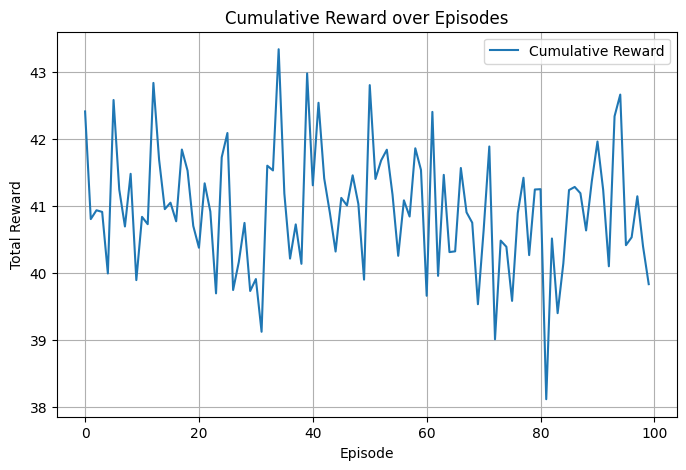

In [3]:
# Plot cumulative reward over episodes
plt.figure(figsize=(8, 5))
plt.plot(episode_rewards, label="Cumulative Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Cumulative Reward over Episodes")
plt.legend()
plt.grid()
plt.show()

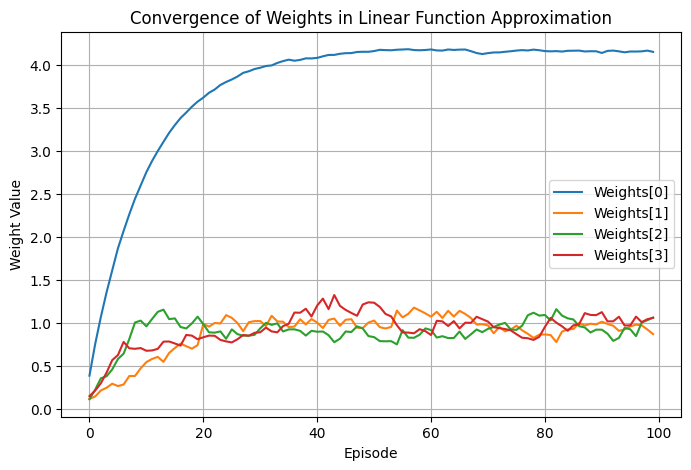

In [24]:
# Plot weights convergence
weights_history = np.array(weights_history)
plt.figure(figsize=(8, 5))
for i in range(weights_history.shape[1]):
    plt.plot(weights_history[:, i], label=f"Weights[{i}]")
plt.xlabel("Episode")
plt.ylabel("Weight Value")
plt.title("Convergence of Weights in Linear Function Approximation")
plt.legend()
plt.grid()
plt.show()

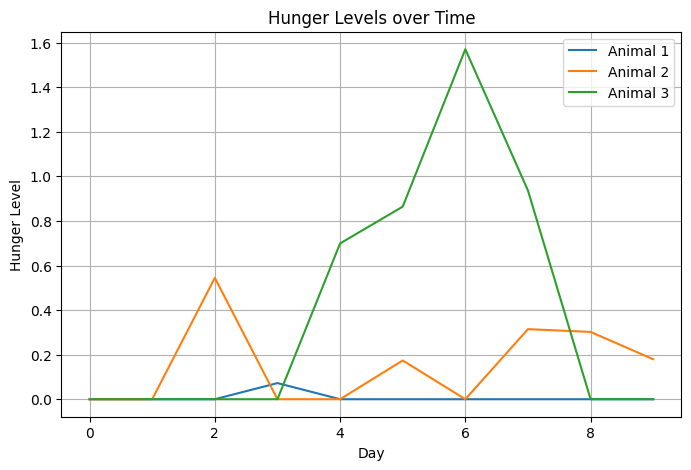

In [6]:
# Simulate policy and plot hunger levels and total utility over time
hunger_history, total_utility = simulate_policy_and_utility(weights)

# Plot hunger levels over time
plt.figure(figsize=(8, 5))
for i in range(hunger_history.shape[1]):
    plt.plot(hunger_history[:, i], label=f"Animal {i+1}")
plt.xlabel("Day")
plt.ylabel("Hunger Level")
plt.title("Hunger Levels over Time")
plt.legend()
plt.grid()
plt.show()

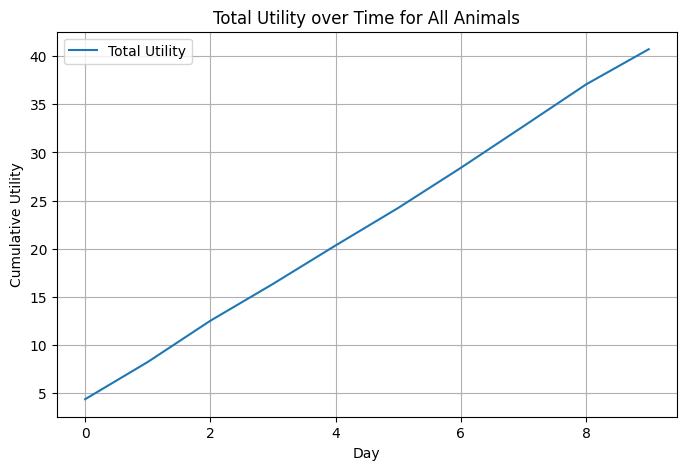

In [7]:
# Plot total utility over time
plt.figure(figsize=(8, 5))
plt.plot(range(T), total_utility, label="Total Utility")
plt.xlabel("Day")
plt.ylabel("Cumulative Utility")
plt.title("Total Utility over Time for All Animals")
plt.legend()
plt.grid()
plt.show()

### Part (E) Answer

- The total reward per episode is very noisy. It bounces around in the 40 and 42 and does not converge on a single fixed value.
- Comparing to $w[1], w[2], and w[3]$, $w[0]$ grows much larger than other three weights.  $w[1], w[2], and w[3]$ grows slowly and have very similar growth rate. Also, the four weights all increase at a logarithmic rate, indicating that the improvement speed is relatively fast in the early iterations and gradually converges to a fixed point in the later iterations.
- Some animals’ (animal 1 & animal 2) hunger level remains near zero because they receive enough food, while others increase a lot (Animal 3).


The reason $w[0]$ performs different and grows much slower is because $w[0]$  multiplies the constant feature. Also, the other three features are normalized in each episode, but $w[0]$ is not. And this effect accumulates on every step of iteration, causing a much faster growth rate.